In [8]:
import glob
import json
import cv2
import numpy as np
from typing import List
import torch
import sys
from torchreid.utils import FeatureExtractor
from dataclasses import dataclass
from pathlib import Path
from zipfile import ZipFile
import shutil
from itertools import groupby
import matplotlib.pyplot as plt 
from tqdm import tqdm
from time import sleep
import math
import gc
import pyrealsense2 as rs

In [2]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.9.0


In [3]:
model_path_0 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_x1_0_imagenet.pth'
model_path_1 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_msmt17_256x128_amsgrad_ep50_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'
model_path_2 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_market1501_256x128_amsgrad_ep100_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'
model_path_3 = '/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_dukemtmcreid_256x128_amsgrad_ep90_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'
extractor = FeatureExtractor(
    model_name = 'osnet_ain_x1_0',
    model_path = model_path_2,
    device='cuda'
)

Successfully loaded imagenet pretrained weights from "/home/eam/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_ain_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "/home/eam/MasterThesis/ReId/deep-person-reid/osnet_ain_x1_0_market1501_256x128_amsgrad_ep100_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


/home/eam/anaconda3/envs/alphapose_yolo4/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [4]:
def get_upper_body_rectangle(bbox: List[int], sub_bbox_ratio):
    """
    convert bbox yo in:
    [x, y, width, height]
    """
    sub_width = int(bbox[2] * sub_bbox_ratio)
    sub_height = int(bbox[3] * sub_bbox_ratio)
    return np.array([int(bbox[0]+(bbox[2]/2) - (sub_width/2)), int(bbox[1]+(bbox[3]/5)), sub_width, sub_height])

In [5]:
def crop(img, bboxes):
    cropped_imgs = []
    for bbox in bboxes:
        bbox = [x for x in bbox]
        cropped = img[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
        cropped_imgs.append(cropped)
    return cropped_imgs

In [6]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x6', force_reload=False)  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /home/eam/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-11-7 torch 1.9.0 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 3914MiB)

Fusing layers... 
Model Summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


In [7]:
def xyxy2xywh(xyxy):
    bbox = xyxy.clone().detach()
    bbox[2:4] = bbox[2:4]-bbox[0:2]
    return bbox

In [23]:
bag_file = "/home/eam/Documents/sequence_office.bag"
composite_frames = []
try:
    # Create pipeline
    pipeline = rs.pipeline()

    # Create a config object
    config = rs.config()

    # Tell config that we will use a recorded device from file to be used by the pipeline through playback.
    rs.config.enable_device_from_file(config, bag_file)


    # Configure the pipeline to stream the depth stream
    # Change this parameters according to the recorded bag file resolution
    config.enable_stream(rs.stream.depth)
    config.enable_stream(rs.stream.color)
    

    # Start streaming from file
    pipeline_profile = pipeline.start(config)
    streams_profile = pipeline_profile.get_streams()
    for profile in streams_profile:
        print("fps: ", profile.fps())
        print("name: ", profile.stream_name())
        print("format: ", profile.format())
        print("type: ", profile.stream_type())
        print("______________________________")
        
        
    
    depth_intrinsic_params = pipeline.get_active_profile().get_stream(rs.stream.depth).as_video_stream_profile().intrinsics
    color_intrinsic_params = pipeline.get_active_profile().get_stream(rs.stream.color).as_video_stream_profile().intrinsics
    
#     depth_intrinsics = IntrinsicsParams(
#         depth_intrinsic_params.coeffs,
#         depth_intrinsic_params.fx,
#         depth_intrinsic_params.fy,
#         depth_intrinsic_params.height,
#         depth_intrinsic_params.width,
#         str(depth_intrinsic_params.model),
#         depth_intrinsic_params.ppx,
#         depth_intrinsic_params.ppy
#     )
#     color_intrinsics = IntrinsicsParams(
#         color_intrinsic_params.coeffs,
#         color_intrinsic_params.fx,
#         color_intrinsic_params.fy,
#         color_intrinsic_params.height,
#         color_intrinsic_params.width,
#         str(color_intrinsic_params.model),
#         color_intrinsic_params.ppx,
#         color_intrinsic_params.ppy
#     )    

    # Create colorizer object
    colorizer = rs.colorizer()
    align = rs.align(rs.stream.color)

    # Streaming loop
    frame_cnt = 0
    prev_frame_number = 0
    while True:
        # Get frameset of depth
        frames = pipeline.wait_for_frames()
        print(frames.get_timestamp())

        if prev_frame_number > frames.get_frame_number():
            cv2.destroyAllWindows()
            break
        prev_frame_number = frames.get_frame_number()


        frames = align.process(frames)
        frames.keep()
        if frames.get_frame_number() == 9456:
            composite_frames.append(frames)
            break
finally:
    cv2.destroyAllWindows()
    pass

fps:  30
name:  Depth
format:  format.z16
type:  stream.depth
______________________________
fps:  30
name:  Color
format:  format.rgb8
type:  stream.color
______________________________
1637320273638.3816
1637320273638.3816
1637320273671.7217
1637320273705.0627
1637320273738.4038
1637320273771.7449
1637320273805.086
1637320273838.427
1637320273871.768
1637320273905.1091
1637320273938.4504
1637320273971.7915
1637320274005.1326
1637320274038.4736
1637320274071.8147
1637320274105.1548
1637320274138.4958
1637320274171.837
1637320274205.178
1637320274238.519
1637320274271.86
1637320274305.2012
1637320274338.5425
1637320274371.8835
1637320274405.2246
1637320274438.5657
1637320274471.9067
1637320274505.2478
1637320274538.588
1637320274571.929
1637320274605.27
1637320274638.611
1637320274671.9521
1637320274705.2932
1637320274738.6343
1637320274771.9753
1637320274805.3164
1637320274838.6575
1637320274871.9988
1637320274905.3398
1637320274938.681
1637320274972.022
1637320275005.362
163732027503

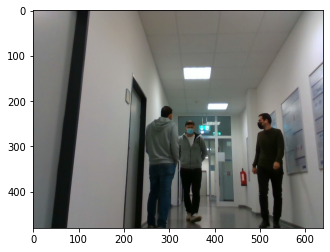

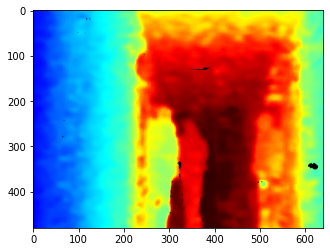

In [78]:
%matplotlib inline
frame = f"/home/eam/MasterThesis/Thesis/deep-sort3d/notebooks/extracted_rs_office/frames/09456.jpg"
depth_info = f"/home/eam/MasterThesis/Thesis/deep-sort3d/notebooks/extracted_rs_office/depth/09456.npy"
colorizer = rs.colorizer()
depth_frame = composite_frames[0].get_depth_frame()

img = plt.imread(frame)
plt.imshow(img)
plt.show()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

plt.show()

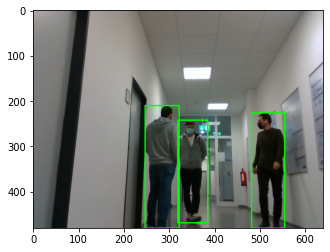

In [82]:
frm = cv2.imread(frame)
result = model(frm, size=1280)
# extract humans with satisfied threshold
detection = [det.to(torch.int) for det in result.pred[0] if det[5] == 0.0 and det[4] > 0.55] 
for obj in detection:
    bbox = xyxy2xywh(obj[0:4]).cpu().detach().numpy()
    frm = cv2.rectangle(frm, bbox[0:2], bbox[0:2] + bbox[2:4], (0,255,0), 2)
dst_frame = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)    
plt.imshow(dst_frame)
plt.savefig("rs_dataset_office.pdf", bbox_inches='tight')
plt.show()

3.812626217332843
4.462610425562245
5.324997989194734


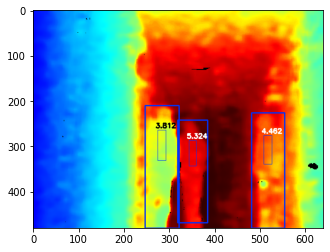

In [83]:
sub_bbox_ratio = 1/4
colorized_depth1 = None
for i, obj in enumerate(detection):
    bbox = xyxy2xywh(obj[0:4]).cpu().detach().numpy()
    upper_body = get_upper_body_rectangle(bbox, sub_bbox_ratio)
    colorized_depth1 = cv2.rectangle(colorized_depth, bbox[0:2], bbox[0:2] + bbox[2:4], (0,50,250), 2)
    colorized_depth1 = cv2.rectangle(colorized_depth1, upper_body[0:2], upper_body[0:2] + upper_body[2:4], (0,50,250), 1)
    
    depth_matrix = np.zeros((depth_frame.height, depth_frame.width))
    for x in range(depth_frame.width):
        for y in range(depth_frame.height):
            depth_matrix[y,x] = depth_frame.get_distance(x,y)
    
    depth_cropped = crop(depth_matrix, [upper_body])[0].mean()
    print(depth_cropped)
    if i == 0:
        cv2.putText(colorized_depth1,str(depth_cropped)[0:5], upper_body[0:2]-5,  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2, 2)
    else:
        cv2.putText(colorized_depth1,str(depth_cropped)[0:5], upper_body[0:2]-5,  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, 2)
    
# dst_frame = cv2.cvtColor(colorized_depth, cv2.COLOR_BGR2RGB)    
plt.imshow(colorized_depth1)
plt.savefig("rs_dataset_office_depth.pdf", bbox_inches='tight')
plt.show()

In [59]:
str(depth_cropped)[0:5]

'3.812'